In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv('data/sarcasm_dataset.csv')


In [110]:
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [163]:
X_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')

# load the labels
y_train = pd.read_csv('data/train_labels.csv')
y_test = pd.read_csv('data/test_labels.csv')

In [112]:
X_train

,headline
0,delta airlines counter agent assures man he wi...
1,longtime employee given small pewter object
2,winneshiek county stadium indeed ready to rock
3,huckabee backs denying abortion to 10-year-old...
4,several injured after 'unauthorized' vehicle e...
...,...
19947,obama requests $3.7 billion to deal with borde...
19948,spouse criticism may worsen chronic low back pain
19949,national weather service to give hurricanes fu...
19950,study: majority of frontal lobe occupied by th...


In [113]:
y_train

,is_sarcastic
0,1
1,1
2,1
3,0
4,0
...,...
19947,0
19948,0
19949,1
19950,1


In [114]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [115]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_40548\1835953282.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['is_sarcastic'], palette='coolwarm')


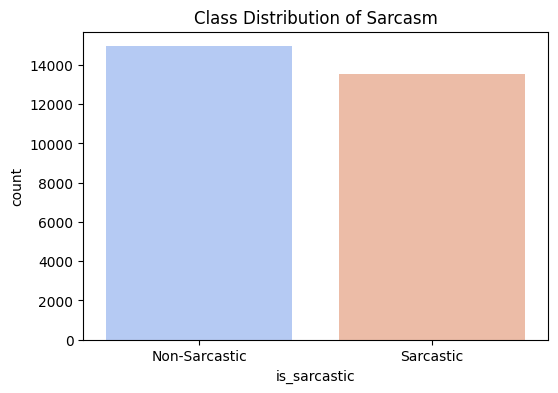

In [116]:
plt.figure(figsize=(6, 4))
sns.countplot(x=data['is_sarcastic'], palette='coolwarm')
plt.title("Class Distribution of Sarcasm")
plt.xticks(ticks=[0, 1], labels=['Non-Sarcastic', 'Sarcastic'])
plt.show()

In [117]:
from tqdm.auto import tqdm

tqdm.pandas()

In [136]:
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', sep='	', encoding='utf-8')
# Get the actual column names from the file
column_names = vad_lexicon.columns
word_col = column_names[0]  # First column should be words
valence_col = column_names[1]  # Second column should be valence
arousal_col = column_names[2]  # Third column should be arousal
dominance_col = column_names[3]  # Fourth column should be dominance

vad_dict = dict(zip(vad_lexicon[word_col], 
                    zip(vad_lexicon[valence_col],
                        vad_lexicon[arousal_col],
                        vad_lexicon[dominance_col])))

def get_vad_scores(text):
    #print(text)
    #words = text.split()
    v_scores = []
    a_scores = []
    d_scores = []
    
    for word in text:
        if word in vad_dict:
            v, a, d = vad_dict[word]
            v_scores.append(float(v))
            a_scores.append(float(a))
            d_scores.append(float(d))
    
    return [np.mean(s) if s else 0 for s in [v_scores, a_scores, d_scores]]

In [159]:
from spacy.lang.en.stop_words import STOP_WORDS

In [162]:
from collections import defaultdict

def clean_text(spacy_doc):
    text = []

    for token in spacy_doc:
        # t = token.lemma_.lower()
        t = token.lemma_
        if t.lower() in STOP_WORDS:
            continue
        if token.pos_ == "PUNCT":
            continue

        if token.pos_ == "NUM":
            t = "NUM"
        
        # if token.pos_ == ""
        
        text.append(t)
    
    return text

POS_tags = list(nlp.get_pipe("tagger").labels)

def process_text(text):
    re = {k:0 for k in POS_tags}
    #re = defaultdict(int)

    spacy_doc = nlp(text)

    re["ents_count"] = len(spacy_doc.ents)
    re["polarity"] = spacy_doc._.blob.polarity
    re["subjectivity"] = spacy_doc._.blob.subjectivity

    text = []

    for token in spacy_doc:
        #t = token.lemma_.lower()
        t = token.lemma_
        re[token.tag_] += 1
        
        if t.lower() in STOP_WORDS:
            continue
        if token.pos_ == "PUNCT":
            continue

        if token.pos_ == "NUM":
            t = "NUM"
        
        # if token.pos_ == ""
        
        text.append(t)
    
    re["cleaned_text"] = text
    # vad_scores = get_vad_scores(text)
    # re["vad_valence"], re["vad_arousal"], re["vad_dominance"] = vad_scores

    return re

def df_process_text(row):
    return pd.Series(process_text(row["headline"]))



In [132]:
label = 1

src = data[data["is_sarcastic"] == label]["headline"].values

#idx = np.random.randint(len(src))
idx = 2419

#text = src[idx]

print(idx)
text = "The Affordable Care Act extended the solvency of the Medicare Trust Fund. billy eichner boogied with obama and ellen got all the details"

# doc = nlp(text.lower())
doc = nlp(text)

v_score = get_vad_scores(text)
# print(" ".join([t.lemma_.lower() for t in doc if t.pos_ != "PUNCT"]))
print(doc)
print(clean_text(doc))
print(v_score)
print(doc._.blob.polarity)
print(doc._.blob.subjectivity)

print(len(doc.ents))

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.ent_type)

2419
The Affordable Care Act extended the solvency of the Medicare Trust Fund. billy eichner boogied with obama and ellen got all the details
The Affordable Care Act extended the solvency of the Medicare Trust Fund. billy eichner boogied with obama and ellen got all the details
['the', 'Affordable', 'Care', 'Act', 'extend', 'the', 'solvency', 'of', 'the', 'Medicare', 'Trust', 'Fund', 'billy', 'eichner', 'boogie', 'with', 'obama', 'and', 'ellen', 'get', 'all', 'the', 'detail']
[0.56175, 0.34099999999999997, 0.5275]
0.0
0.0
2
The the DET DT 390
Affordable Affordable PROPN NNP 390
Care Care PROPN NNP 390
Act Act PROPN NNP 390
extended extend VERB VBD 0
the the DET DT 0
solvency solvency NOUN NN 0
of of ADP IN 0
the the DET DT 383
Medicare Medicare PROPN NNP 383
Trust Trust PROPN NNP 383
Fund Fund PROPN NNP 383
. . PUNCT . 0
billy billy PROPN NNP 0
eichner eichner PROPN NNP 0
boogied boogie VERB VBD 0
with with ADP IN 0
obama obama NOUN NN 0
and and CCONJ CC 0
ellen ellen ADJ JJ 0
got get 

In [77]:
data = data.join(data.progress_apply(df_process_text, axis=1))

100%|██████████| 28503/28503 [03:47<00:00, 125.17it/s]


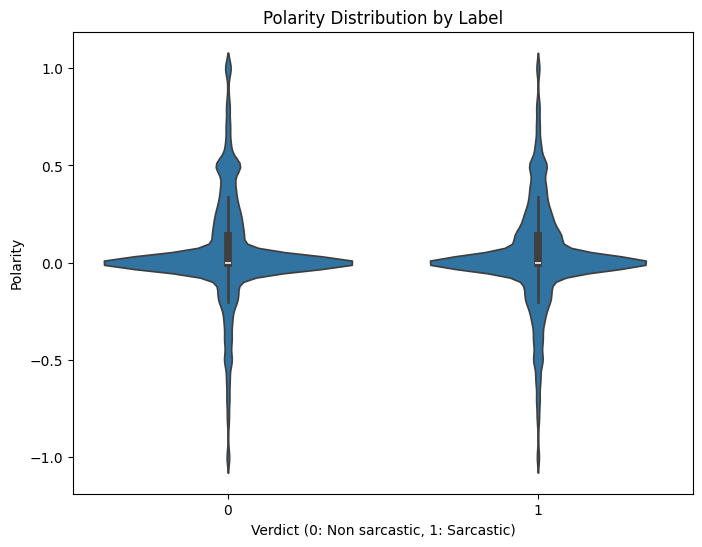

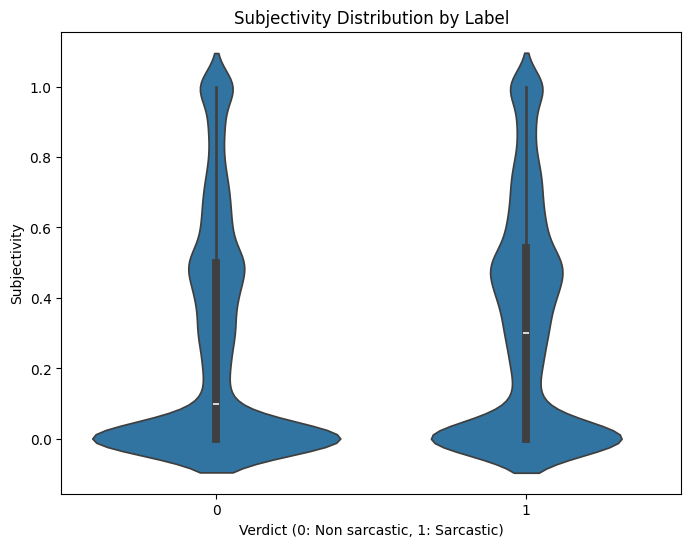

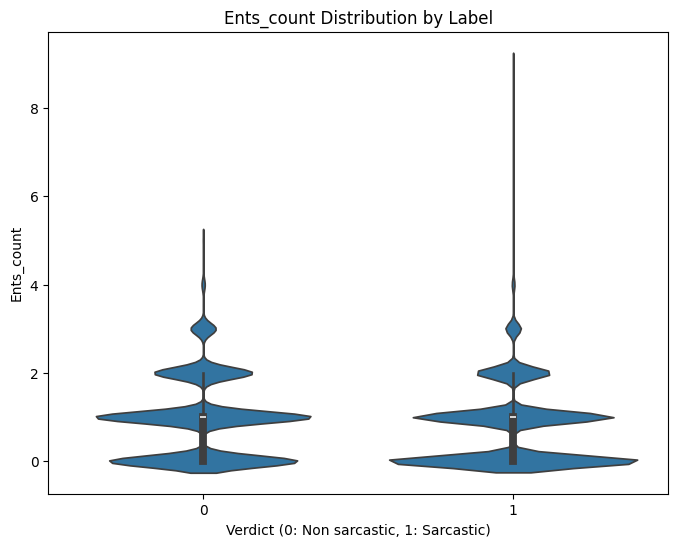

In [78]:
features_to_plot = ["polarity", "subjectivity", "ents_count"]
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="is_sarcastic", y=feature, data=data)
    plt.title(f"{feature.capitalize()} Distribution by Label")
    plt.xlabel("Verdict (0: Non sarcastic, 1: Sarcastic)")
    plt.ylabel(feature.capitalize())
    plt.show()

In [79]:
data

,is_sarcastic,headline,$,'',",",-LRB-,-RRB-,.,:,ADD,...,WP,WP$,WRB,XX,_SP,``,ents_count,polarity,subjectivity,cleaned_text
0,1,thirtysomething scientists unveil doomsday clo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.000000,0.000000,"[thirtysomethe, scientist, unveil, doomsday, c..."
1,0,dem rep. totally nails why congress is falling...,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0.000000,0.525000,"[dem, rep, ., totally, nail, why, congress, be..."
2,0,eat your veggies: 9 deliciously different recipes,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.000000,0.600000,"[eat, your, veggie, NUM, deliciously, differen..."
3,1,inclement weather prevents liar from getting t...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,"[inclement, weather, prevent, liar, from, get,..."
4,1,mother comes pretty close to using word 'strea...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.250000,1.000000,"[mother, come, pretty, close, to, use, word, s..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28498,1,jews to celebrate rosh hashasha or something,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.000000,0.000000,"[jews, to, celebrate, rosh, hashasha, or, some..."
28499,1,internal affairs investigator disappointed con...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.083333,0.416667,"[internal, affairs, investigator, disappoint, ..."
28500,0,the most beautiful acceptance speech this week...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0.675000,0.750000,"[the, most, beautiful, acceptance, speech, thi..."
28501,1,mars probe destroyed by orbiting spielberg-gat...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.000000,0.000000,"[mars, probe, destroy, by, orbit, spielberg, g..."


In [138]:
X_train = X_train.join(X_train.progress_apply(df_process_text, axis=1))

100%|██████████| 19952/19952 [03:15<00:00, 102.09it/s]


In [139]:
X_test = X_test.join(X_test.progress_apply(df_process_text, axis=1))

100%|██████████| 8551/8551 [01:25<00:00, 100.09it/s]


In [140]:
X_train

,headline,$,'',",",-LRB-,-RRB-,.,:,ADD,AFX,...,XX,_SP,``,ents_count,polarity,subjectivity,cleaned_text,vad_valence,vad_arousal,vad_dominance
0,delta airlines counter agent assures man he wi...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.00,0.00,"[delta, airline, counter, agent, assure, man, ...",0.666375,0.407750,0.653875
1,longtime employee given small pewter object,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.25,0.40,"[longtime, employee, give, small, pewter, object]",0.527167,0.328333,0.390500
2,winneshiek county stadium indeed ready to rock,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.20,0.50,"[winneshiek, county, stadium, indeed, ready, t...",0.626750,0.417750,0.590250
3,huckabee backs denying abortion to 10-year-old...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.00,0.00,"[huckabee, back, deny, abortion, to, NUM, year...",0.306000,0.570167,0.415500
4,several injured after 'unauthorized' vehicle e...,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0.00,0.00,"[several, injure, after, unauthorized, vehicle...",0.480200,0.492400,0.429600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19947,obama requests $3.7 billion to deal with borde...,1,0,0,0,0,0,0,0,0,...,0,0,0,2,0.00,0.00,"[obama, request, $, NUM, NUM, to, deal, with, ...",0.489500,0.565750,0.504000
19948,spouse criticism may worsen chronic low back pain,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00,0.15,"[spouse, criticism, may, worsen, chronic, low,...",0.366571,0.484143,0.384571
19949,national weather service to give hurricanes fu...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.35,0.55,"[national, weather, service, to, give, hurrica...",0.605571,0.433714,0.595857
19950,study: majority of frontal lobe occupied by th...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.00,0.00,"[study, majority, of, frontal, lobe, occupy, b...",0.550000,0.405875,0.565875


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

In [142]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    max_features=5000,
    ngram_range=(1,2)
)
temp = vectorizer.fit_transform(X_train["cleaned_text"])
train_df_tfidf = pd.DataFrame(
    temp.toarray(), columns=vectorizer.get_feature_names_out()
)

temp = vectorizer.transform(X_test["cleaned_text"])
test_df_tfidf = pd.DataFrame(temp.toarray(), columns=vectorizer.get_feature_names_out())

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [143]:
train_df_tfidf

,,#,$,$ NUM,%,% of,&,',' 80,' NUM,...,your life,yourself,youth,youtube,z,zika,zone,zoo,zuckerberg,
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19947,0.0,0.0,0.247053,0.247250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19948,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19949,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19950,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
X_train['headline'][0]

'delta airlines counter agent assures man he will never see his family again'

In [145]:
y_train['is_sarcastic'][0]

1

In [146]:
transfer_columns = [c for c in X_train.columns if c not in ["headline", "cleaned_text"]]

train_df_fin = pd.concat([train_df_tfidf, X_train[transfer_columns].add_prefix('I_')], axis=1)
test_df_fin = pd.concat([test_df_tfidf, X_test[transfer_columns].add_prefix('I_')], axis=1)

In [147]:
train_y = y_train['is_sarcastic']

In [148]:
train_y

0        1
1        1
2        1
3        0
4        0
        ..
19947    0
19948    0
19949    1
19950    1
19951    1
Name: is_sarcastic, Length: 19952, dtype: int64

In [149]:
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report

In [151]:
model = LogisticRegression(class_weight="balanced", max_iter=2000, C=2)
model.fit(train_df_fin,train_y)

LogisticRegression(C=2, class_weight='balanced', max_iter=2000)

In [152]:
y_train_pred = model.predict(train_df_fin)

score_train = f1_score(train_y, y_train_pred, average="macro")

print(score_train)
print(classification_report(train_y, y_train_pred))

0.9093647294498849
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     10400
           1       0.90      0.91      0.91      9552

    accuracy                           0.91     19952
   macro avg       0.91      0.91      0.91     19952
weighted avg       0.91      0.91      0.91     19952



In [153]:
test_y = y_test['is_sarcastic']


In [154]:
y_test_pred = model.predict(test_df_fin)

score_test = f1_score(test_y, y_test_pred, average="macro")

print(score_test)
print(classification_report(test_y, y_test_pred))

0.848723490419918
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4551
           1       0.84      0.84      0.84      4000

    accuracy                           0.85      8551
   macro avg       0.85      0.85      0.85      8551
weighted avg       0.85      0.85      0.85      8551



In [155]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [156]:
explainer = shap.Explainer(model, train_df_fin)


shap_values = explainer(test_df_fin)

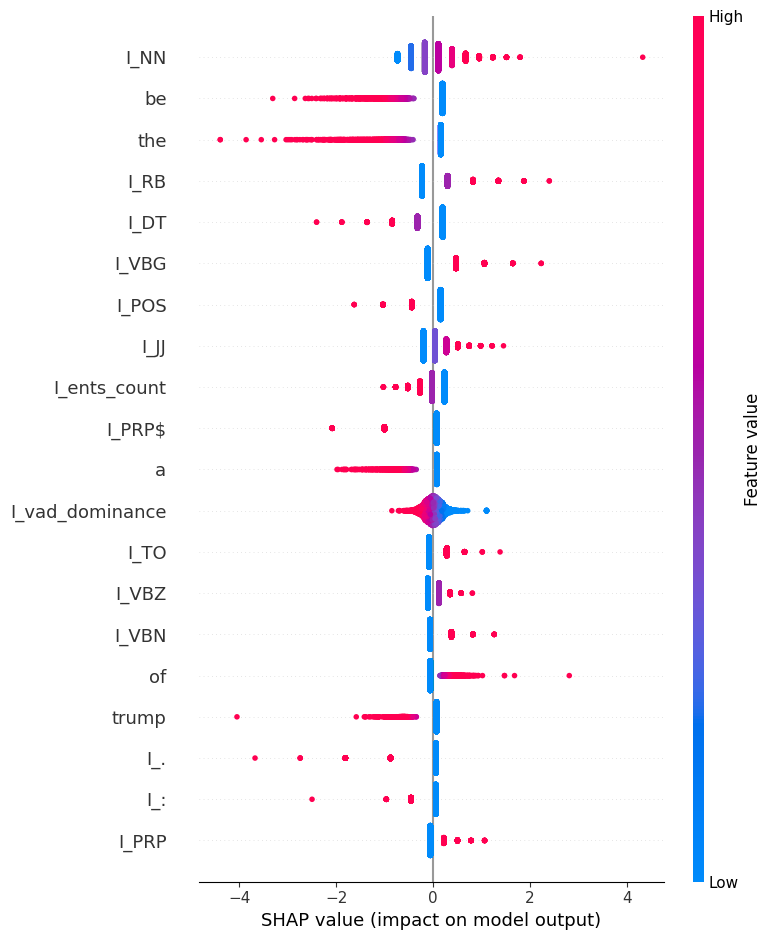

In [157]:
shap.summary_plot(shap_values, test_df_fin)


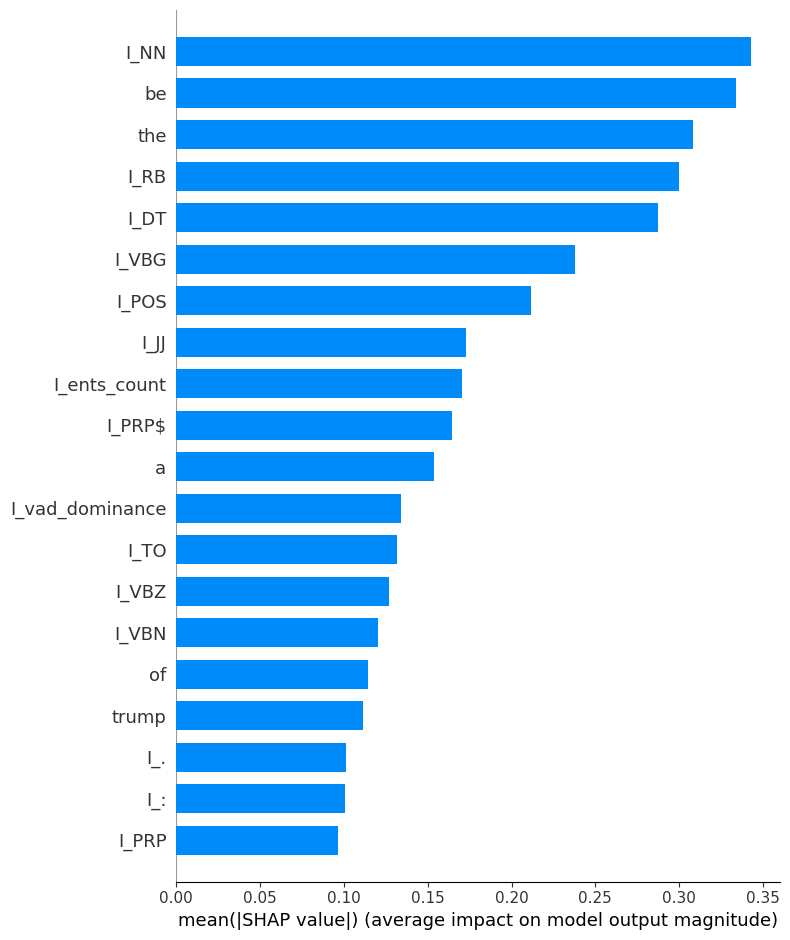

In [158]:
shap.summary_plot(shap_values, test_df_fin, plot_type="bar")
